In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from numba import njit
import cv2
from scipy.optimize import curve_fit

In [3]:
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

# def wiener_deconvolution(weight, psf, K=0.01, dtype=np.float64):
#     """
#     Perform Wiener deconvolution on an weight function using the given PSF.
#     """
#     print("Deconvolving weight function")
#     # Convert to wanted dtype
#     weight = weight.astype(dtype, copy=False)
#     psf = psf[::-1, ::-1].astype(dtype, copy=False)
#
#     # Compute padded shape
#     pad_shape = [s1 + s2 - 1 for s1, s2 in zip(weight.shape, psf.shape)]
#
#     # Center PSF in padded array
#     psf_padded = np.zeros(pad_shape, dtype=dtype)
#     y0 = pad_shape[0] // 2 - psf.shape[0] // 2
#     x0 = pad_shape[1] // 2 - psf.shape[1] // 2
#     psf_padded[y0 : y0 + psf.shape[0], x0 : x0 + psf.shape[1]] = psf
#
#     # Compute FFTs of image and PSF
#     psf_fft = fft2(ifftshift(psf_padded))
#     weight_fft = fft2(weight, pad_shape)
#
#     # Wiener deconvolve
#     denom = (psf_fft * np.conj(psf_fft)) + K
#     result_fft = (np.conj(psf_fft) * weight_fft) / denom
#     result = np.real(ifft2(result_fft))
#
#     # Crop back to original image size
#     result = result[:weight.shape[0], :weight.shape[1]]
#     return result



def sersic(
    width,
    height,
    xc,
    yc,
    k,
    n,
    inclination=0,
    rotation=0,
    n_arms=0,
    winding=1,
    bulge_strength=1,
    Rc=30,
    direction=1,
):
    """
    Compute the Sersic galaxy centered at (xc, yc)
    """
    y, x = np.indices((width, height), dtype=float)
    x_rel = x - xc
    y_rel = y - yc

    # Transform to polar coordinates
    r = np.sqrt(x_rel**2 + y_rel**2)
    theta = np.arctan2(y_rel, x_rel) * direction

    # Calculate the bulge
    bulge = np.exp(-k * r ** (1 / n))

    # Add arms
    if n_arms > 0:
        arms = 1 + np.cos(n_arms * (theta - winding * np.log(r + 1e-6)))
    else:
        arms = 0

    # Add the arms and bulge together
    galaxy = bulge * bulge_strength + arms * np.exp(-((r / Rc) ** 2))

    # Flatten the image due to inclination
    scale_y = np.cos(inclination)
    M_incline = np.float32([[1, 0, 0], [0, scale_y, yc * (1 - scale_y)]])
    galaxy_inclined = cv2.warpAffine(
        galaxy, M_incline, (width, height), flags=cv2.INTER_CUBIC
    )

    # Rotate around (xc, yc)
    M_rot = cv2.getRotationMatrix2D((xc, yc), np.degrees(rotation), 1.0)
    galaxy_final = cv2.warpAffine(
        galaxy_inclined, M_rot, (width, height), flags=cv2.INTER_CUBIC
    )

    return galaxy_final


def moffat(
    height,
    width,
    m: float,
    a: float,
    n_spikes: int = 0,
    rotation: float = 0.0,
    spike_strength: float = 2.0,
    spike_width: float = 4.0,
    Rc: float = 10.0,
):
    """
    Calculate the PSF following moffat and add spikes if wanted
    """
    y, x = np.indices((height, width), dtype=float)
    xc, yc = width / 2, height / 2
    x_rel = x - xc
    y_rel = y - yc

    # Transform to polar coordinates
    r = np.sqrt(x_rel**2 + y_rel**2)
    theta = np.arctan2(y_rel, x_rel) + rotation

    # Calculate the center shape of the PSF
    center = (1 + (r / a) ** 2) ** (-m)

    # Calculate the spikes
    spikes = np.zeros_like(center)
    for i in range(n_spikes):
        angle = i * 2 * np.pi / n_spikes
        dist = np.abs(np.cos(theta - angle))
        spikes += np.exp(-((dist / spike_width) ** 2))

    # Add the spikes to the center
    moffat = center + spike_strength * spikes * np.exp(-((r / Rc) ** 2))
    return moffat / moffat.sum()

def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return image[y0:y1, x0:x1]


def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window


@njit
def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

# @njit(fastmath=True)
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"] * W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]

def elliptical_gaussian(coords, A, x0, y0, sigma_x, sigma_y, theta):
    """
    2D elliptical Gaussian with rotation.
    
    coords : tuple of (x, y) flattened
    """
    x, y = coords
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    
    x_shift = x - x0
    y_shift = y - y0
    
    x_rot = cos_t * x_shift + sin_t * y_shift
    y_rot = -sin_t * x_shift + cos_t * y_shift
    
    g = A * np.exp(-0.5 * ((x_rot/sigma_x)**2 + (y_rot/sigma_y)**2))
    return g.ravel()

def deconv_gaussian_rms(image):
    """
    Fit an elliptical Gaussian to the deconvolved image
    and compute RMS error.
    
    Parameters
    ----------
    image : 2D array
        Deconvolved image
    
    Returns
    -------
    rms_error : float
        Root-mean-square difference relative to max of image
    fit_params : dict
        Fitted Gaussian parameters: A, x0, y0, sigma_x, sigma_y, theta
    """
    ny, nx = image.shape
    y, x = np.indices(image.shape)
    
    # Initial guess
    A0 = image.max()
    x0 = nx / 2
    y0 = ny / 2
    sigma_x = nx / 4
    sigma_y = ny / 4
    theta = 0.0
    p0 = (A0, x0, y0, sigma_x, sigma_y, theta)
    
    try:
        popt, _ = curve_fit(
            elliptical_gaussian,
            (x.ravel(), y.ravel()),
            image.ravel(),
            p0=p0,
            bounds=(
                [0, 0, 0, 0, 0, -np.pi/2],
                [np.inf, nx, ny, nx, ny, np.pi/2]
            )
        )
    except RuntimeError:
        # fit failed
        return np.inf, None
    
    # Reconstruct Gaussian
    fit_image = elliptical_gaussian((x, y), *popt).reshape(image.shape)
    
    # RMS error relative to max
    rms_error = np.sqrt(np.mean((image - fit_image)**2)) / image.max()
    
    fit_params = {
        "A": popt[0],
        "x0": popt[1],
        "y0": popt[2],
        "sigma_x": popt[3],
        "sigma_y": popt[4],
        "theta": popt[5]
    }
    
    return rms_error, fit_params

def find_deconvolution(weight, psf, K=1e-6):
    """
    Find the deconvolved weight function using Wiener deconvolution.
    """
    height, width = weight.shape
    K /= 10
    rms = np.inf
    while rms > 0.01 and K < 1e-2:
        K *= 10
        psf_cache = prepare_wiener_psf(psf, [height, width], K=K)
        weight_deconv = wiener_deconvolution_fast(weight, psf_cache)
        weight_deconv /= np.sum(weight_deconv)
        rms, _ = deconv_gaussian_rms(weight_deconv)
    return weight_deconv, K

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"] * W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]

def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale

# def calculate_gaap_flux(image, psf_cache, weight, centers):
#     """
#     Placeholder function for flux calculation.
#     """
#     weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
#     flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

#     centers = np.asarray(centers)
#     ys = centers[:, 1]
#     xs = centers[:, 0]

#     valid = np.isfinite(xs) & np.isfinite(ys)
#     measured_F = np.full(len(centers), np.nan, dtype=np.float32)
#     measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

#     return measured_F, weight_rescale


def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

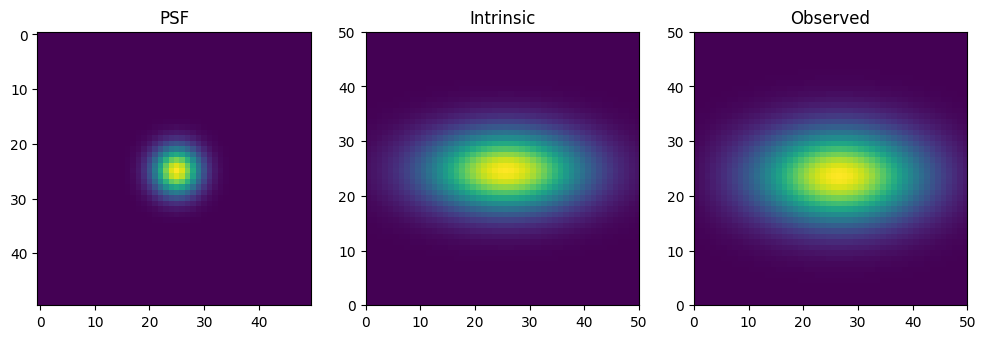

In [35]:
width = 50
height = 50
source_x_sigma = 10
source_y_sigma = 5
# Create PSF and Galaxy images
psf_sigma = 3
image_psf = gaussian_weight(height, width, height / 2, width / 2, psf_sigma, psf_sigma)
image_intrinsic = gaussian_weight(height, width, height / 2, width / 2, source_x_sigma, source_y_sigma) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf)
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [36]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 8, 8)
psf_cache = prepare_wiener_psf(image_psf, [height, width], K=1e-15)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')
# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, weight_ne = calculate_gaap_flux(image, psf_cache, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 1.338757
The aperture flux using the observed image and rescaled weight function : -5.500173


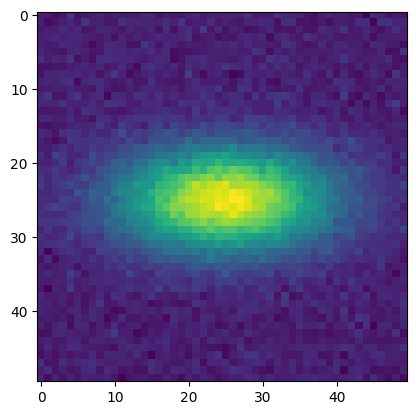

In [37]:
noise = np.random.normal(0, .1, (height, width))
plt.imshow(image_intrinsic + noise)
plt.show()

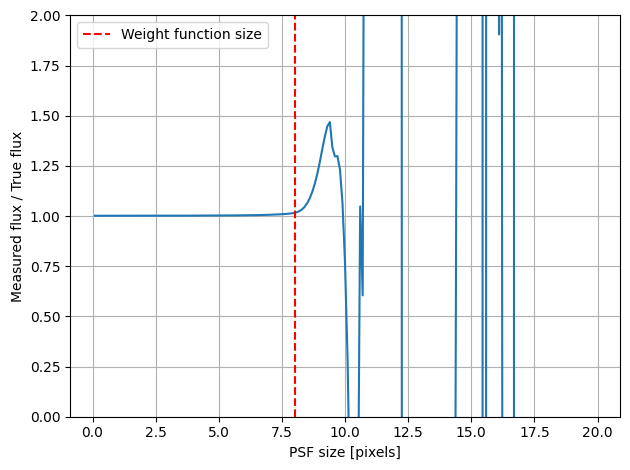

In [26]:
weight = gaussian_weight(height, width, height / 2, width / 2, 8, 8)
psf_sizes = np.arange(.1, 20, .1)
true_F = np.sum(weight * image_intrinsic)
measured_F = np.zeros_like(psf_sizes)
for i, psf_size in enumerate(psf_sizes):
    psf = gaussian_weight(height, width, height / 2, width / 2, psf_size, psf_size)
    cache = prepare_wiener_psf(psf, [height, width], K=1e-15)
    new_image = fftconvolve(image_intrinsic, psf, mode="same")
    F, _ = calculate_gaap_flux(new_image + noise, cache, weight, [(height / 2, width / 2)])
    measured_F[i] = F[0]
plt.plot(psf_sizes, measured_F / true_F)
plt.axvline(8, linestyle='--', color='red', label='Weight function size')
plt.xlabel('PSF size [pixels]')
plt.ylabel('Measured flux / True flux')
plt.ylim(0, 2)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/flux_psf_size.pdf')
plt.show()

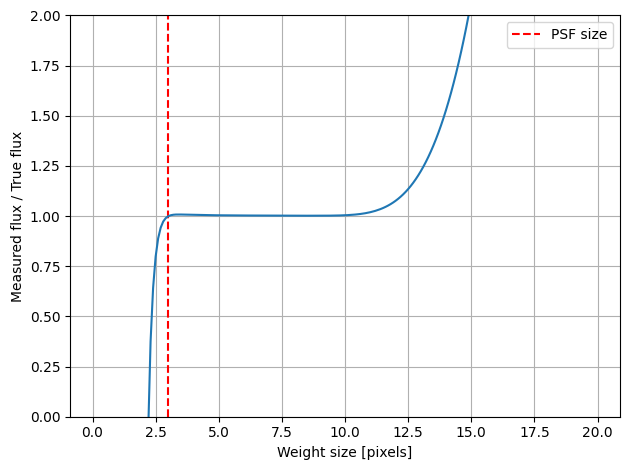

In [27]:
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-15)
weight_sizes = np.arange(.1, 20, .1)
true_F = np.zeros_like(weight_sizes)
measured_F = np.zeros_like(weight_sizes)
for i, weight_size in enumerate(weight_sizes):
    image_weight = gaussian_weight(height, width, height / 2, width / 2, weight_size, weight_size)
    F, _ = calculate_gaap_flux(image + noise, cache, image_weight, [(height / 2, width / 2)])
    true_F[i] = np.sum(image_weight * image_intrinsic)
    measured_F[i] = F[0]
plt.axvline(psf_sigma, linestyle='--', color='red', label='PSF size')
plt.plot(weight_sizes, measured_F / true_F)
plt.xlabel('Weight size [pixels]')
plt.ylabel('Measured flux / True flux')
plt.ylim(0, 2)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/flux_weight_size.pdf')
plt.show()

In [40]:
# size grids
psf_sizes = np.linspace(1e-5, 2, 200)
weight_sizes = np.linspace(1e-5, 2, 200)

ratio = np.zeros((len(weight_sizes), len(psf_sizes)))

# precompute noise once
noise_image = noise.copy()

for j, psf_size in enumerate(psf_sizes):
    print(j)
    psf = gaussian_weight(
        height, width,
        height / 2, width / 2,
        psf_size, psf_size
    )

    cache = prepare_wiener_psf(psf, [height, width], K=1e-15)

    blurred = fftconvolve(image_intrinsic, psf, mode="same")
    for i, weight_size in enumerate(weight_sizes):

        weight = gaussian_weight(
            height, width,
            height / 2, width / 2,
            weight_size, weight_size
        )

        true_F = np.sum(weight * image_intrinsic)


        F, _ = calculate_gaap_flux(
            blurred + noise_image,
            cache,
            weight,
            [(height / 2, width / 2)]
        )

        ratio[i, j] = F[0] / true_F


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


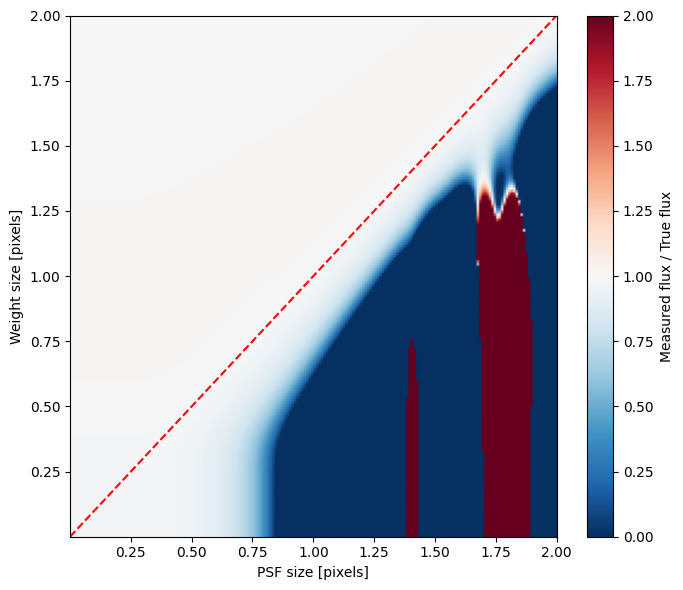

In [41]:
plt.figure(figsize=(7, 6))

im = plt.imshow(
    ratio,
    origin="lower",
    aspect="auto",
    extent=[
        psf_sizes[0], psf_sizes[-1],
        weight_sizes[0], weight_sizes[-1]
    ],
    vmin=0,
    vmax=2,
    cmap="RdBu_r"
)

plt.colorbar(im, label="Measured flux / True flux")
plt.plot([min(psf_sizes), max(psf_sizes)], [min(psf_sizes), max(psf_sizes)], 'r--')
plt.xlabel("PSF size [pixels]")
plt.ylabel("Weight size [pixels]")

plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/flux_weight_psf_size0.pdf')
plt.show()


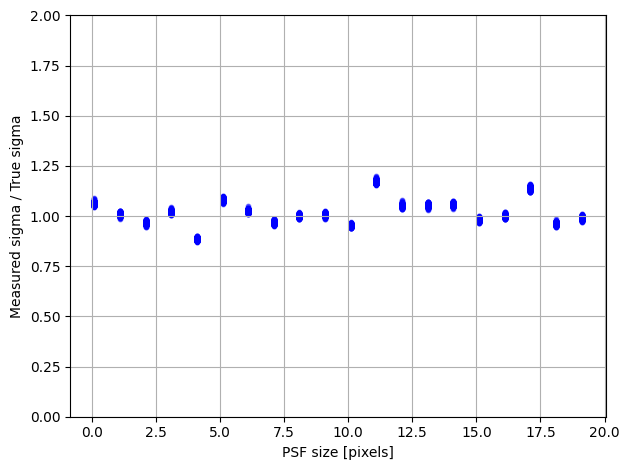

In [9]:
weight = gaussian_weight(height, width, height / 2, width / 2, 8, 8)
psf_sizes = np.arange(.1, 20, 1)
N_trials = 200
for i, psf_size in enumerate(psf_sizes):
    psf = gaussian_weight(height, width, height / 2, width / 2, psf_size, psf_size)
    cache = prepare_wiener_psf(psf, [height, width], K=1e-15)
    image = fftconvolve(image_intrinsic, psf, mode="same")
    fluxes = np.zeros(N_trials)
    sigmas = np.zeros(N_trials)
    for j in range(N_trials):
        noise = np.random.normal(0, .3, (height, width))
        F, weight_rescale = calculate_gaap_flux(image + noise, cache, weight, [(height / 2, width / 2)])
        sigma = estimate_sigma(noise, weight_rescale, maxlag=0)
        fluxes[j] = F[0]
        sigmas[j] = sigma
    plt.scatter(psf_size * np.ones(N_trials), sigmas / np.std(fluxes), s=10, color='blue', alpha=0.5)
plt.xlabel('PSF size [pixels]')
plt.ylabel('Measured sigma / True sigma')
plt.ylim(0, 2)
plt.grid()
plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/error_psf_size.pdf')
plt.show()

noise size 1
noise size 2
noise size 3
noise size 4
noise size 5
noise size 6
noise size 7
noise size 8
noise size 9
noise size 10
noise size 11
noise size 12
noise size 13
noise size 14
noise size 15
noise size 16
noise size 17
noise size 18
noise size 19


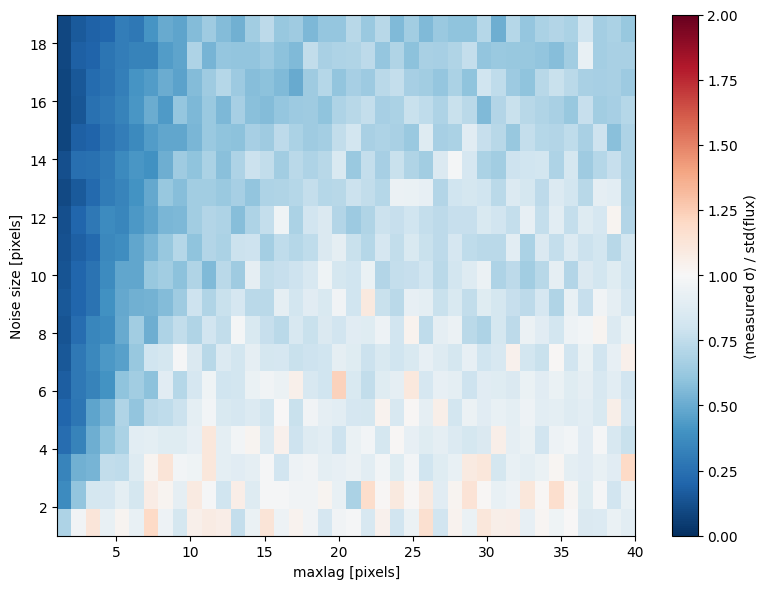

In [ ]:
weight = gaussian_weight(height, width, height / 2, width / 2, 8, 8)
image = fftconvolve(image_intrinsic, image_psf, mode="same")
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-15)

noise_sizes = np.arange(1, 20, 1)
maxlags = np.arange(1, 41, 1)
N_trials = 50

ratio = np.zeros((len(noise_sizes), len(maxlags)))

for i, noise_size in enumerate(noise_sizes):
    print(f"noise size {noise_size}")
    noise_psf = gaussian_weight(
        height, width,
        height / 2, width / 2,
        noise_size, noise_size
    )

    for k, maxlag in enumerate(maxlags):
        fluxes = np.zeros(N_trials)
        sigmas = np.zeros(N_trials)

        for j in range(N_trials):
            noise = np.random.normal(0, 1, (height, width)) * 0.1
            noise = fftconvolve(noise, noise_psf, mode="same")

            F, weight_rescale = calculate_gaap_flux(
                image + noise, cache, weight, [(height / 2, width / 2)]
            )
            sigma = estimate_sigma(noise, weight_rescale, maxlag=maxlag)

            fluxes[j] = F[0]
            sigmas[j] = sigma

        ratio[i, k] = np.nanmean(sigmas) / np.std(fluxes)

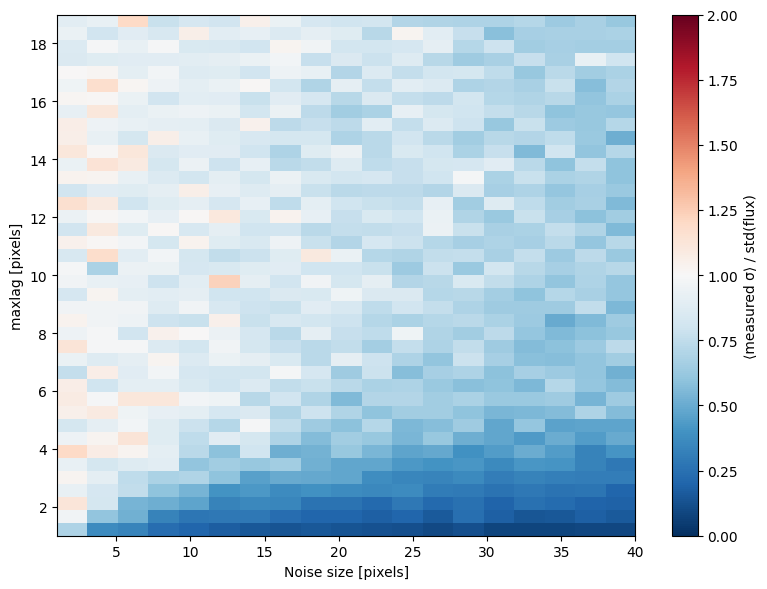

In [13]:
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=2.0)
plt.figure(figsize=(8, 6))
plt.imshow(
    ratio.T,
    origin="lower",
    aspect="auto",
    extent=[maxlags[0], maxlags[-1], noise_sizes[0], noise_sizes[-1]],
    cmap="RdBu_r",
    norm=norm
)
plt.colorbar(label="⟨measured σ⟩ / std(flux)")

plt.ylabel("maxlag [pixels]")
plt.xlabel("Noise size [pixels]")
plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/error_covariance_size.pdf')
plt.show()

/var/tmp/deklerk/ipykernel_3489199/3926403385.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
/var/tmp/deklerk/ipykernel_3489199/3926403385.py:31: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(original_sizes, np.sqrt(original_sizes**2 - psf_sigma**2), color='green', label='Expected relation')


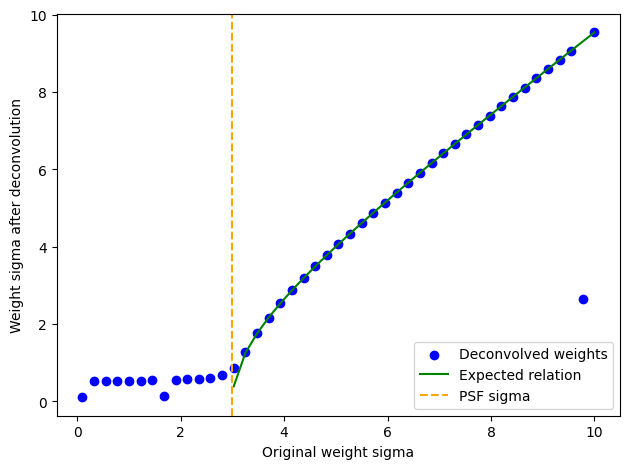

In [8]:
from scipy.optimize import curve_fit
original_sizes = np.linspace(0.1, 10, 45)
weight_sigmas = np.full(len(original_sizes), np.nan)
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-15)
for i, original_size in enumerate(original_sizes):
    weight = gaussian_weight(height, width, height / 2, width / 2, original_size, original_size)
    weight_rescale = wiener_deconvolution_fast(weight, cache)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]
    try:
        popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)

        amplitude, weight_sigma, x0, y0,  = popt
        weight_sigmas[i] = weight_sigma
    except RuntimeError:
        plt.imshow(weight_rescale)
        plt.title(f'Fit failed for original size {original_size}')
        plt.show()
        continue
plt.scatter(original_sizes, np.abs(weight_sigmas), color='blue', label='Deconvolved weights')
plt.plot(original_sizes, np.sqrt(original_sizes**2 - psf_sigma**2), color='green', label='Expected relation')
plt.xlabel('Original weight sigma')
plt.ylabel('Weight sigma after deconvolution')
plt.axvline(psf_sigma, color='orange', linestyle='--', label='PSF sigma')
plt.legend()
plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/deconvolution_relation.pdf')
plt.show()

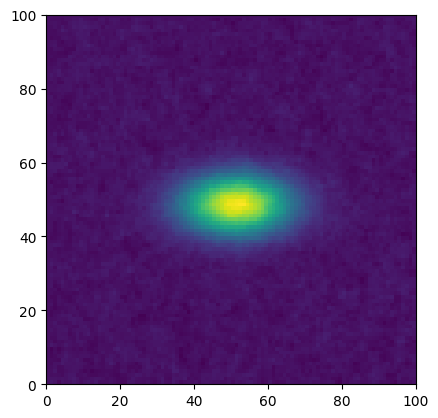

In [ ]:
noise_psf = moffat(width, height, 2, 1)
noise = np.random.normal(0, .1, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same")
noisy_image = image + noise
plt.imshow(noisy_image, extent=(0, width, 0, height))
plt.show()

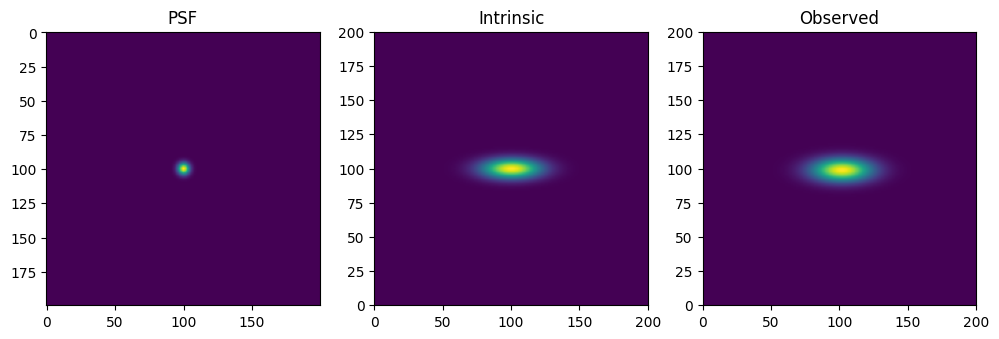

In [20]:
width = 200
height = 200
source_x_sigma = 15
source_y_sigma = 5
# Create PSF and Galaxy images
psf_sigma = 3
image_psf = gaussian_weight(height, width, height / 2, width / 2, psf_sigma, psf_sigma)
image_intrinsic = gaussian_weight(height, width, height / 2, width / 2, source_x_sigma, source_y_sigma) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf)
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

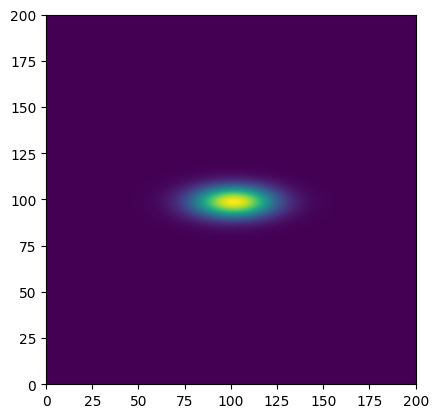

In [21]:
noise = np.random.normal(0, .1, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same")
noisy_image = image + noise
plt.imshow(noisy_image, extent=(0, width, 0, height))
plt.show()

In [22]:
sizes = np.linspace(0.1, 30, 50)
snr = np.zeros((len(sizes), len(sizes)))
maxlag = 0
cache = prepare_wiener_psf(image_psf, [width, height], K=1e-15)
max_gaussian_size = None
max_gaussian_snr = -np.inf
for i, size_x in enumerate(sizes):
    for j, size_y in enumerate(sizes):
        weight = gaussian_weight(
            width, height,
            width / 2, height / 2,
            size_x, size_y
        )
        flux, weight_new = calculate_gaap_flux(
            noisy_image, cache, weight, [(width / 2, height / 2)]
        )
        sigma = estimate_sigma(noise, weight_new, maxlag)
        snr[i, j] = flux[0] / sigma
        if i == j and snr[i, j] > max_gaussian_snr:
            max_gaussian_snr = snr[i, j]
            max_gaussian_size = size_x

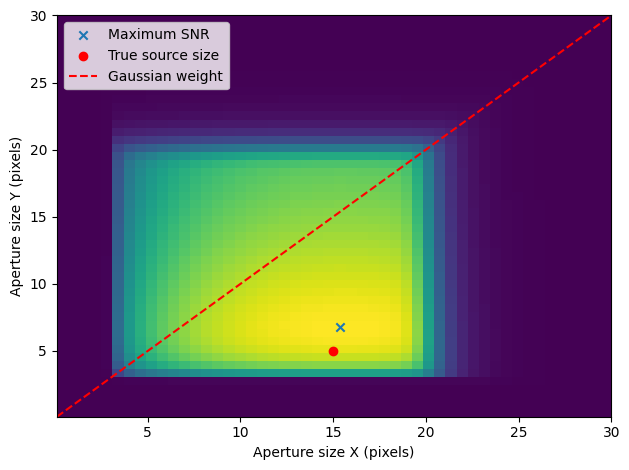

Best gaussian snr: 20577.64411608828 at size: 9.863265306122448
Best elliptical snr: 22998.06605445572 at sizes: 15.355102040816325 6.812244897959183


In [23]:
# location of maximum SNR
imax, jmax = np.unravel_index(np.argmax(snr), snr.shape)

plt.figure()
plt.imshow(
    snr.T,
    origin="lower",
    extent=[sizes[0], sizes[-1], sizes[0], sizes[-1]],
    aspect="auto"
)
# plt.colorbar(label="SNR")
plt.scatter(sizes[imax], sizes[jmax], marker="x", label='Maximum SNR')
plt.scatter(source_x_sigma, source_y_sigma, marker="o", color="red", label="True source size")
plt.plot(sizes, sizes, color="red", linestyle="--", label="Gaussian weight")
plt.xlabel("Aperture size X (pixels)")
plt.ylabel("Aperture size Y (pixels)")
plt.legend()
plt.tight_layout()
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/aperture_size.pdf')
plt.show()
print('Best gaussian snr:', max_gaussian_snr, 'at size:', max_gaussian_size)
print('Best elliptical snr:', np.max(snr), 'at sizes:', sizes[imax], sizes[jmax])

5.0


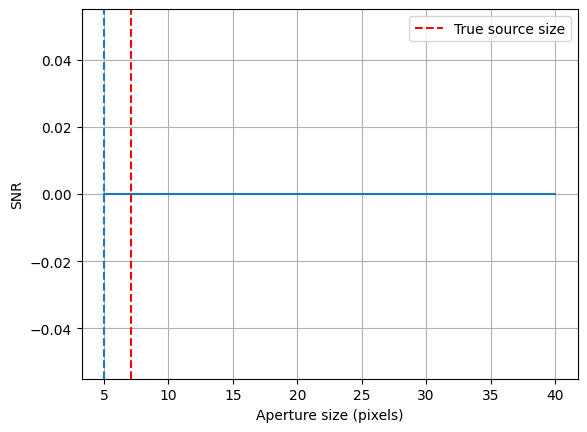

In [ ]:
sizes = np.linspace(5, 40, 20)
snr = np.zeros_like(sizes) 
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-10)
maxlag = 10
for i, size in enumerate(sizes):
    weight = gaussian_weight(height, width, height / 2, width / 2, size, size)
    flux, weight_new = calculate_gaap_flux(noisy_image, cache, weight, [(height / 2, width / 2)])
    sigma = estimate_sigma(noise, weight_new, maxlag)
    snr[i] = flux[0] / sigma
plt.plot(sizes, snr)
plt.axvline(sizes[np.argmax(snr)], linestyle='dashed')
plt.axvline(np.sqrt(source_x_sigma*source_y_sigma), color='red', linestyle='dashed', label='True source size')
print(sizes[np.argmax(snr)])
plt.xlabel("Aperture size (pixels)")
plt.ylabel("SNR")
plt.grid()
plt.legend()
plt.show()